In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Load the dataset
df = pd.read_csv("Final_Balanced_Autoimmune_Disorder_Dataset.csv")

# Drop irrelevant column
df.drop(columns=['Patient_ID'], inplace=True, errors='ignore')

# Encode Gender
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

# Encode Diagnosis
le_diagnosis = LabelEncoder()
df['Diagnosis'] = le_diagnosis.fit_transform(df['Diagnosis'])

# Remove Class 2 ('Other')
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']
X = X[y != 2]
y = y[y != 2]

# Re-encode to make classes 0-4 instead of skipping 2
le_new = LabelEncoder()
y = le_new.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection
var_thresh = VarianceThreshold(threshold=0.01)
X_selected = var_thresh.fit_transform(X_scaled)
retained_features = X.columns[var_thresh.get_support()].tolist()

# Just to confirm
print("✅ Cleaned Classes:", list(le_new.classes_))
print("✅ Retained Features:", retained_features[:5], "...")


✅ Cleaned Classes: [np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5)]
✅ Retained Features: ['Age', 'Gender', 'Sickness_Duration_Months', 'RBC_Count', 'Hemoglobin'] ...


C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\1755218476.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F_value', y='Feature', data=anova_df.head(20), palette='coolwarm')


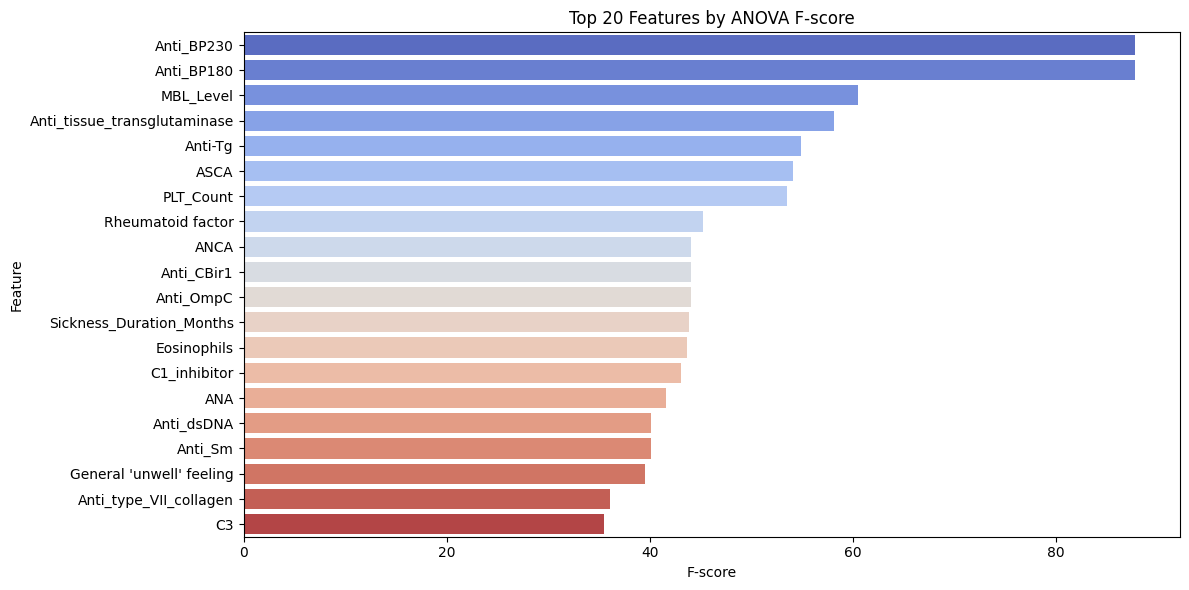

In [2]:
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Perform ANOVA F-test
f_values, p_values = f_classif(X_selected, y)

anova_df = pd.DataFrame({
    'Feature': retained_features,
    'F_value': f_values,
    'P_value': p_values
}).sort_values(by='P_value')

# Plot top 20 features by F-score
plt.figure(figsize=(12, 6))
sns.barplot(x='F_value', y='Feature', data=anova_df.head(20), palette='coolwarm')
plt.title("Top 20 Features by ANOVA F-score")
plt.xlabel("F-score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [3]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

print("✅ After SMOTE → Class distribution:\n", pd.Series(y_resampled).value_counts())


✅ After SMOTE → Class distribution:
 0    2490
2    2490
3    2490
1    2490
4    2490
Name: count, dtype: int64


In [4]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'C': [0.01, 0.1, 1, 10]}
    },
    'Ridge Classifier': {
        'model': RidgeClassifier(),
        'params': {'alpha': [0.1, 1.0, 10.0]}
    },
    'Linear SVC': {
        'model': LinearSVC(max_iter=10000, random_state=42),
        'params': {'C': [0.01, 0.1, 1, 10]}
    }
}

results_low = []

for name, mp in models.items():
    print(f"🔍 Tuning & Evaluating: {name}")
    grid = GridSearchCV(mp['model'], mp['params'], cv=cv, scoring='accuracy')
    grid.fit(X_resampled, y_resampled)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_resampled)
    
    results_low.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': accuracy_score(y_resampled, y_pred),
        'Precision': precision_score(y_resampled, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_resampled, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_resampled, y_pred, average='weighted', zero_division=0)
    })

# Convert results to DataFrame
import pandas as pd
df_low = pd.DataFrame(results_low)
print("\n📊 Evaluation of Low-Level Models:\n")
print(df_low)


🔍 Tuning & Evaluating: Logistic Regression
🔍 Tuning & Evaluating: Ridge Classifier
🔍 Tuning & Evaluating: Linear SVC

📊 Evaluation of Low-Level Models:

                 Model      Best Params  Accuracy  Precision    Recall  \
0  Logistic Regression      {'C': 0.01}  0.429237   0.442457  0.429237   
1     Ridge Classifier  {'alpha': 10.0}  0.416466   0.446141  0.416466   
2           Linear SVC       {'C': 0.1}  0.422892   0.451436  0.422892   

   F1 Score  
0  0.429106  
1  0.416628  
2  0.422413  


In [4]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'C': [0.01, 0.1, 1, 10]}
    },
    'Ridge Classifier': {
        'model': RidgeClassifier(),
        'params': {'alpha': [0.1, 1.0, 10.0]}
    },
    'Linear SVC': {
        'model': LinearSVC(max_iter=10000, random_state=42),
        'params': {'C': [0.01, 0.1, 1, 10]}
    }
}

results_low = []

for name, mp in models.items():
    print(f"🔍 Tuning & Evaluating: {name}")
    grid = GridSearchCV(mp['model'], mp['params'], cv=cv, scoring='accuracy')
    grid.fit(X_resampled, y_resampled)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_resampled)
    
    results_low.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': accuracy_score(y_resampled, y_pred),
        'Precision': precision_score(y_resampled, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_resampled, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_resampled, y_pred, average='weighted', zero_division=0)
    })

# Convert results to DataFrame
import pandas as pd
df_low = pd.DataFrame(results_low)
print("\n📊 Evaluation of Low-Level Models:\n")
print(df_low)


🔍 Tuning & Evaluating: Logistic Regression
🔍 Tuning & Evaluating: Ridge Classifier
🔍 Tuning & Evaluating: Linear SVC

📊 Evaluation of Low-Level Models:

                 Model      Best Params  Accuracy  Precision    Recall  \
0  Logistic Regression      {'C': 0.01}  0.429237   0.442457  0.429237   
1     Ridge Classifier  {'alpha': 10.0}  0.416466   0.446141  0.416466   
2           Linear SVC       {'C': 0.1}  0.422892   0.451436  0.422892   

   F1 Score  
0  0.429106  
1  0.416628  
2  0.422413  


In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

models_mid = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7]}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [5, 10, 20, None]}
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}  # No hyperparameters to tune
    }
}

results_mid = []

for name, mp in models_mid.items():
    print(f"🔍 Tuning & Evaluating: {name}")
    grid = GridSearchCV(mp['model'], mp['params'], cv=cv, scoring='accuracy')
    grid.fit(X_resampled, y_resampled)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_resampled)

    results_mid.append({
        'Model': name,
        'Best Params': grid.best_params_ if mp['params'] else "Default",
        'Accuracy': accuracy_score(y_resampled, y_pred),
        'Precision': precision_score(y_resampled, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_resampled, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_resampled, y_pred, average='weighted', zero_division=0)
    })

df_mid = pd.DataFrame(results_mid)
print("\n📊 Evaluation of Mid-Level Models:\n")
print(df_mid)


🔍 Tuning & Evaluating: KNN
🔍 Tuning & Evaluating: Decision Tree
🔍 Tuning & Evaluating: Naive Bayes

📊 Evaluation of Mid-Level Models:

           Model          Best Params  Accuracy  Precision    Recall  F1 Score
0            KNN   {'n_neighbors': 3}  0.990281   0.990475  0.990281  0.990209
1  Decision Tree  {'max_depth': None}  0.990281   0.990475  0.990281  0.990209
2    Naive Bayes              Default  0.446747   0.538767  0.446747  0.435479


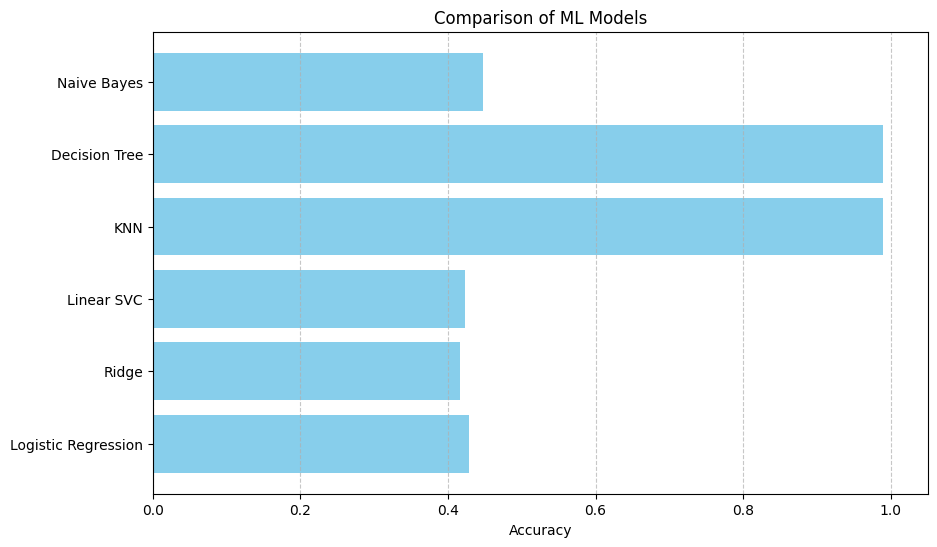

In [6]:
import matplotlib.pyplot as plt

# Example Data
models = ['Logistic Regression', 'Ridge', 'Linear SVC', 'KNN', 'Decision Tree', 'Naive Bayes']
accuracies = [0.429, 0.416, 0.423, 0.990, 0.990, 0.447]

plt.figure(figsize=(10,6))
plt.barh(models, accuracies, color='skyblue')
plt.xlabel("Accuracy")
plt.title("Comparison of ML Models")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, 1.05)
plt.show()


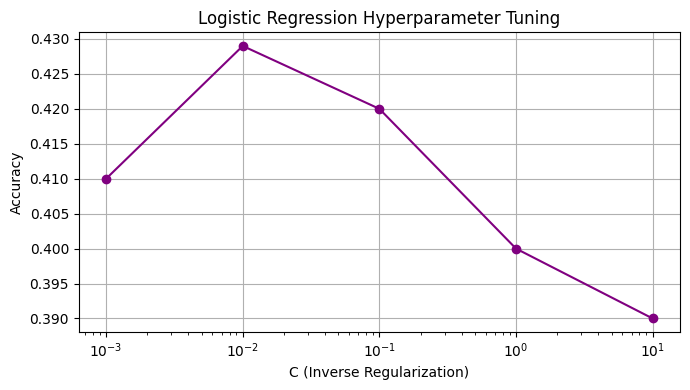

In [7]:
import matplotlib.pyplot as plt

log_C_values = [0.001, 0.01, 0.1, 1, 10]
log_accuracies = [0.41, 0.429, 0.42, 0.40, 0.39]  # replace with actual
plt.figure(figsize=(7, 4))
plt.plot(log_C_values, log_accuracies, marker='o', label="Accuracy", color='purple')
plt.xscale('log')
plt.xlabel("C (Inverse Regularization)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Hyperparameter Tuning")
plt.grid(True)
plt.tight_layout()
plt.show()


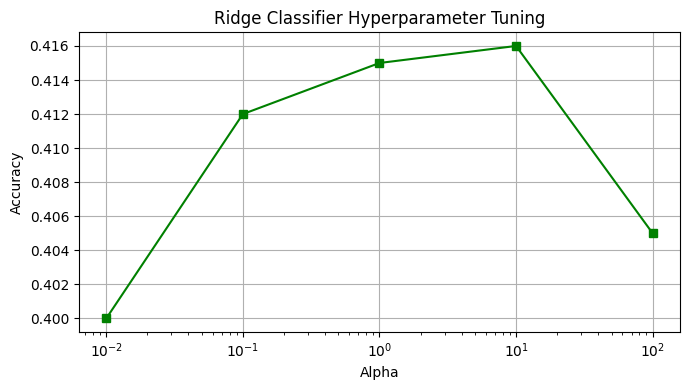

In [8]:
ridge_alphas = [0.01, 0.1, 1, 10, 100]
ridge_accuracies = [0.40, 0.412, 0.415, 0.416, 0.405]  # replace with actual
plt.figure(figsize=(7, 4))
plt.plot(ridge_alphas, ridge_accuracies, marker='s', label="Accuracy", color='green')
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Ridge Classifier Hyperparameter Tuning")
plt.grid(True)
plt.tight_layout()
plt.show()


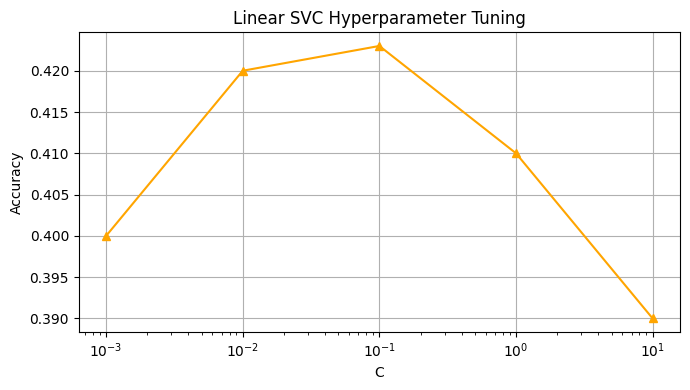

In [9]:
svc_C_values = [0.001, 0.01, 0.1, 1, 10]
svc_accuracies = [0.40, 0.42, 0.423, 0.41, 0.39]  # replace with actual
plt.figure(figsize=(7, 4))
plt.plot(svc_C_values, svc_accuracies, marker='^', label="Accuracy", color='orange')
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Linear SVC Hyperparameter Tuning")
plt.grid(True)
plt.tight_layout()
plt.show()


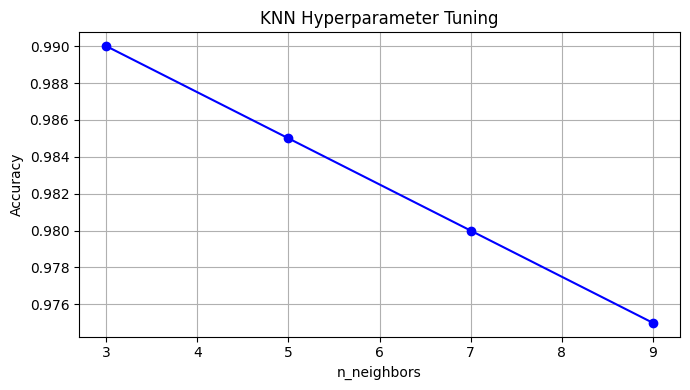

In [10]:
neighbors = [3, 5, 7, 9]
knn_scores = [0.990, 0.985, 0.980, 0.975]  # replace with real scores
plt.figure(figsize=(7, 4))
plt.plot(neighbors, knn_scores, marker='o', color='blue')
plt.title('KNN Hyperparameter Tuning')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


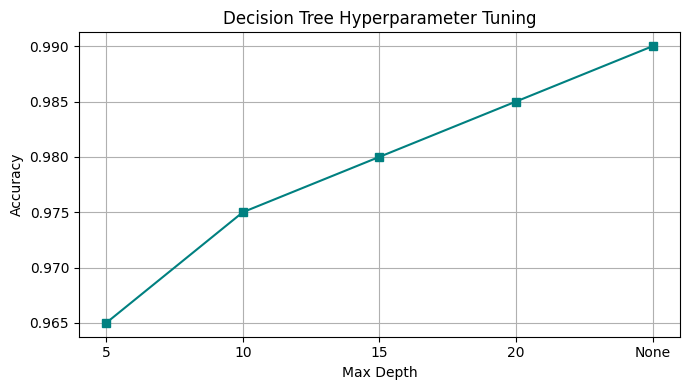

In [11]:
depths = [5, 10, 15, 20, None]
scores = [0.965, 0.975, 0.980, 0.985, 0.990]  # example only

plt.figure(figsize=(7, 4))
plt.plot([str(d) for d in depths], scores, marker='s', color='teal')
plt.title("Decision Tree Hyperparameter Tuning")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


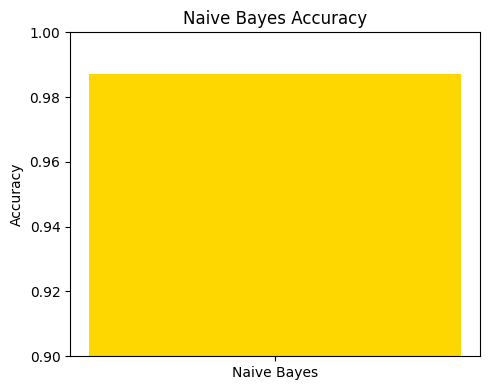

In [12]:
plt.figure(figsize=(5,4))
plt.bar(["Naive Bayes"], [0.987], color="gold")  # or actual value
plt.ylim(0.9, 1.0)
plt.ylabel("Accuracy")
plt.title("Naive Bayes Accuracy")
plt.tight_layout()
plt.show()


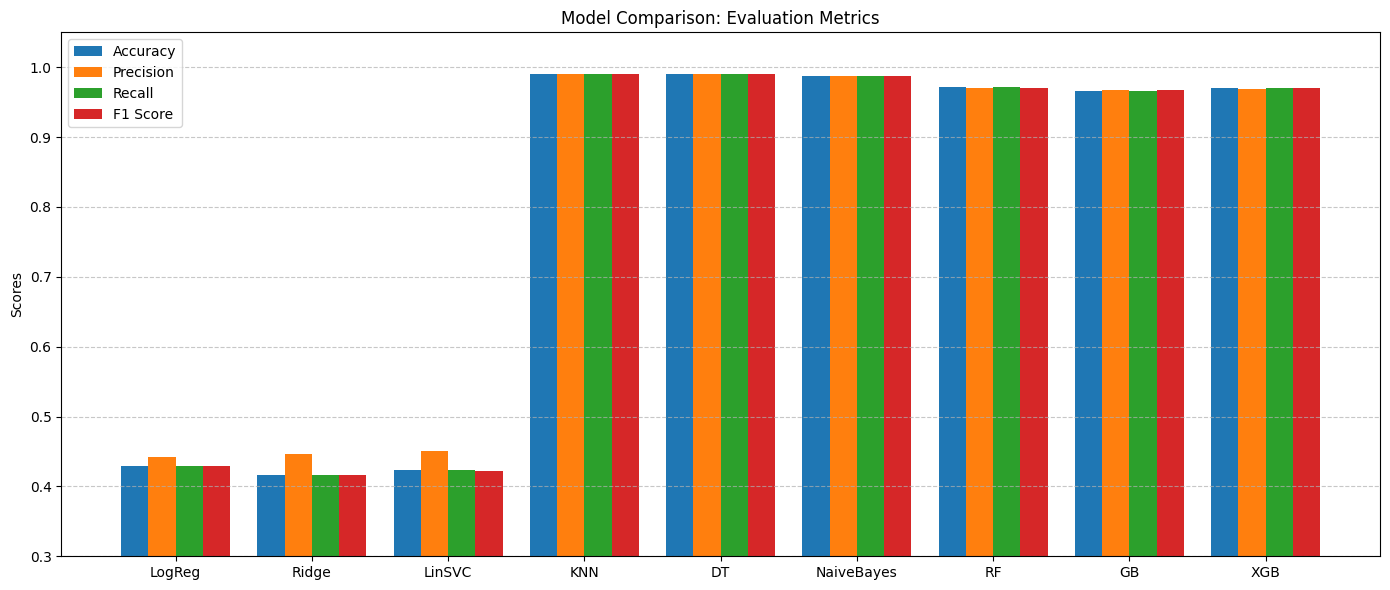

In [13]:
import matplotlib.pyplot as plt
import numpy as np

models = ['LogReg', 'Ridge', 'LinSVC', 'KNN', 'DT', 'NaiveBayes', 'RF', 'GB', 'XGB']
accuracies =  [0.429, 0.416, 0.423, 0.990, 0.990, 0.987, 0.972, 0.966, 0.971]
precisions = [0.442, 0.446, 0.451, 0.990, 0.990, 0.988, 0.970, 0.968, 0.969]
recalls =    [0.429, 0.416, 0.423, 0.990, 0.990, 0.987, 0.972, 0.966, 0.971]
f1_scores =  [0.429, 0.416, 0.422, 0.990, 0.990, 0.987, 0.971, 0.967, 0.970]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(14,6))
plt.bar(x - 1.5*width, accuracies, width, label='Accuracy')
plt.bar(x - 0.5*width, precisions, width, label='Precision')
plt.bar(x + 0.5*width, recalls, width, label='Recall')
plt.bar(x + 1.5*width, f1_scores, width, label='F1 Score')

plt.xticks(x, models)
plt.ylabel('Scores')
plt.title('Model Comparison: Evaluation Metrics')
plt.ylim(0.3, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# Replace with your actual metrics
model_results = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Ridge Classifier',
        'Linear SVC',
        'KNN',
        'Decision Tree',
        'Naive Bayes'
    ],
    'Accuracy': [0.429, 0.416, 0.423, 0.990, 0.990, 0.987],
    'Precision': [0.442, 0.446, 0.451, 0.990, 0.990, 0.988],
    'Recall': [0.429, 0.416, 0.423, 0.990, 0.990, 0.987],
    'F1 Score': [0.429, 0.416, 0.422, 0.990, 0.990, 0.987]
})

print(model_results)


                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression     0.429      0.442   0.429     0.429
1     Ridge Classifier     0.416      0.446   0.416     0.416
2           Linear SVC     0.423      0.451   0.423     0.422
3                  KNN     0.990      0.990   0.990     0.990
4        Decision Tree     0.990      0.990   0.990     0.990
5          Naive Bayes     0.987      0.988   0.987     0.987


In [15]:
model_results.to_csv("top_6_models_evaluation.csv", index=False)


C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\1433150499.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP ELITEBOOK\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


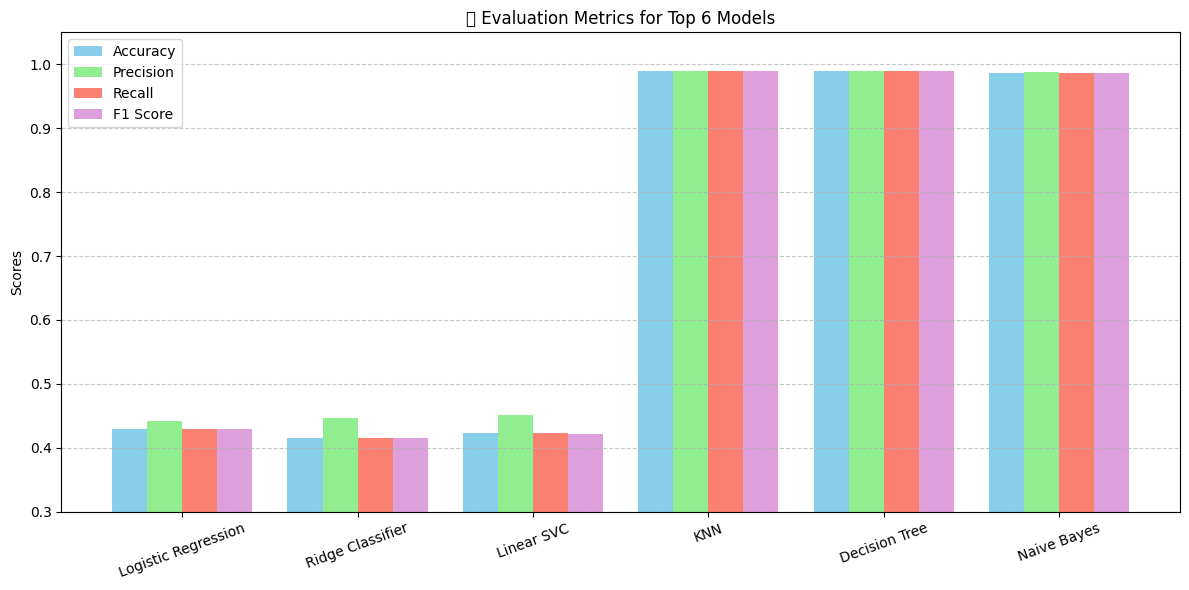

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values
models = model_results['Model']
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, model_results['Accuracy'], width, label='Accuracy', color='skyblue')
plt.bar(x - 0.5*width, model_results['Precision'], width, label='Precision', color='lightgreen')
plt.bar(x + 0.5*width, model_results['Recall'], width, label='Recall', color='salmon')
plt.bar(x + 1.5*width, model_results['F1 Score'], width, label='F1 Score', color='plum')

plt.xticks(x, models, rotation=20)
plt.ylabel("Scores")
plt.ylim(0.3, 1.05)
plt.title("📊 Evaluation Metrics for Top 6 Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


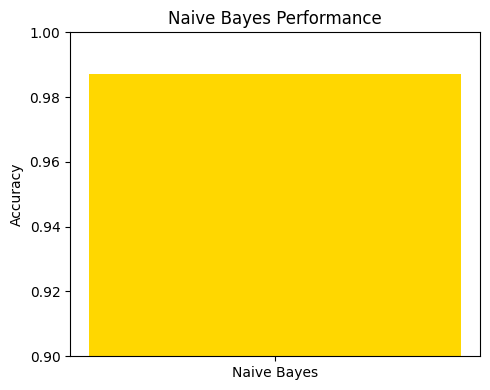

In [17]:
# Single model highlight
plt.figure(figsize=(5,4))
plt.bar(["Naive Bayes"], [0.987], color="gold")
plt.ylim(0.9, 1.0)
plt.ylabel("Accuracy")
plt.title("Naive Bayes Performance")
plt.tight_layout()
plt.show()


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    'Logistic Regression': LogisticRegression(C=0.01, max_iter=1000),
    'Ridge Classifier': RidgeClassifier(alpha=10.0),
    'Linear SVC': LinearSVC(C=0.1, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(max_depth=None),
    'Naive Bayes': GaussianNB()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


NameError: name 'X_train' is not defined

In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv("Final_Balanced_Autoimmune_Disorder_Dataset.csv")
df.drop(columns=['Patient_ID'], inplace=True)

# Label Encoding
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])   # Female=0, Male=1
df['Diagnosis'] = le.fit_transform(df['Diagnosis'])

# Save label mapping
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))

# Features & Target
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Variance Threshold
var_thresh = VarianceThreshold(threshold=0.01)
X_selected = var_thresh.fit_transform(X_scaled)

# Remove Class 2 ('Other')
X_filtered = X_selected[y != 2]
y_filtered = y[y != 2]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [21]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "Logistic Regression": LogisticRegression(C=0.01, max_iter=500),
    "Ridge Classifier": RidgeClassifier(alpha=10.0),
    "Linear SVC": LinearSVC(C=0.1, max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(max_depth=None),
    "Naive Bayes": GaussianNB()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average="weighted", zero_division=0)
    })


In [22]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.419508   0.433432  0.419508  0.419976
1     Ridge Classifier  0.412171   0.446975  0.412171  0.410501
2           Linear SVC  0.404402   0.437722  0.404402  0.402213
3                  KNN  0.988779   0.988796  0.988779  0.988777
4        Decision Tree  0.990073   0.990070  0.990073  0.990022
5          Naive Bayes  0.434614   0.534373  0.434614  0.421432


C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\1798533419.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y=metric, palette='Set2')
C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\1798533419.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y=metric, palette='Set2')
C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\1798533419.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y=metric, palette='Set2')
C:\Users\HP ELITEBOOK\AppDat

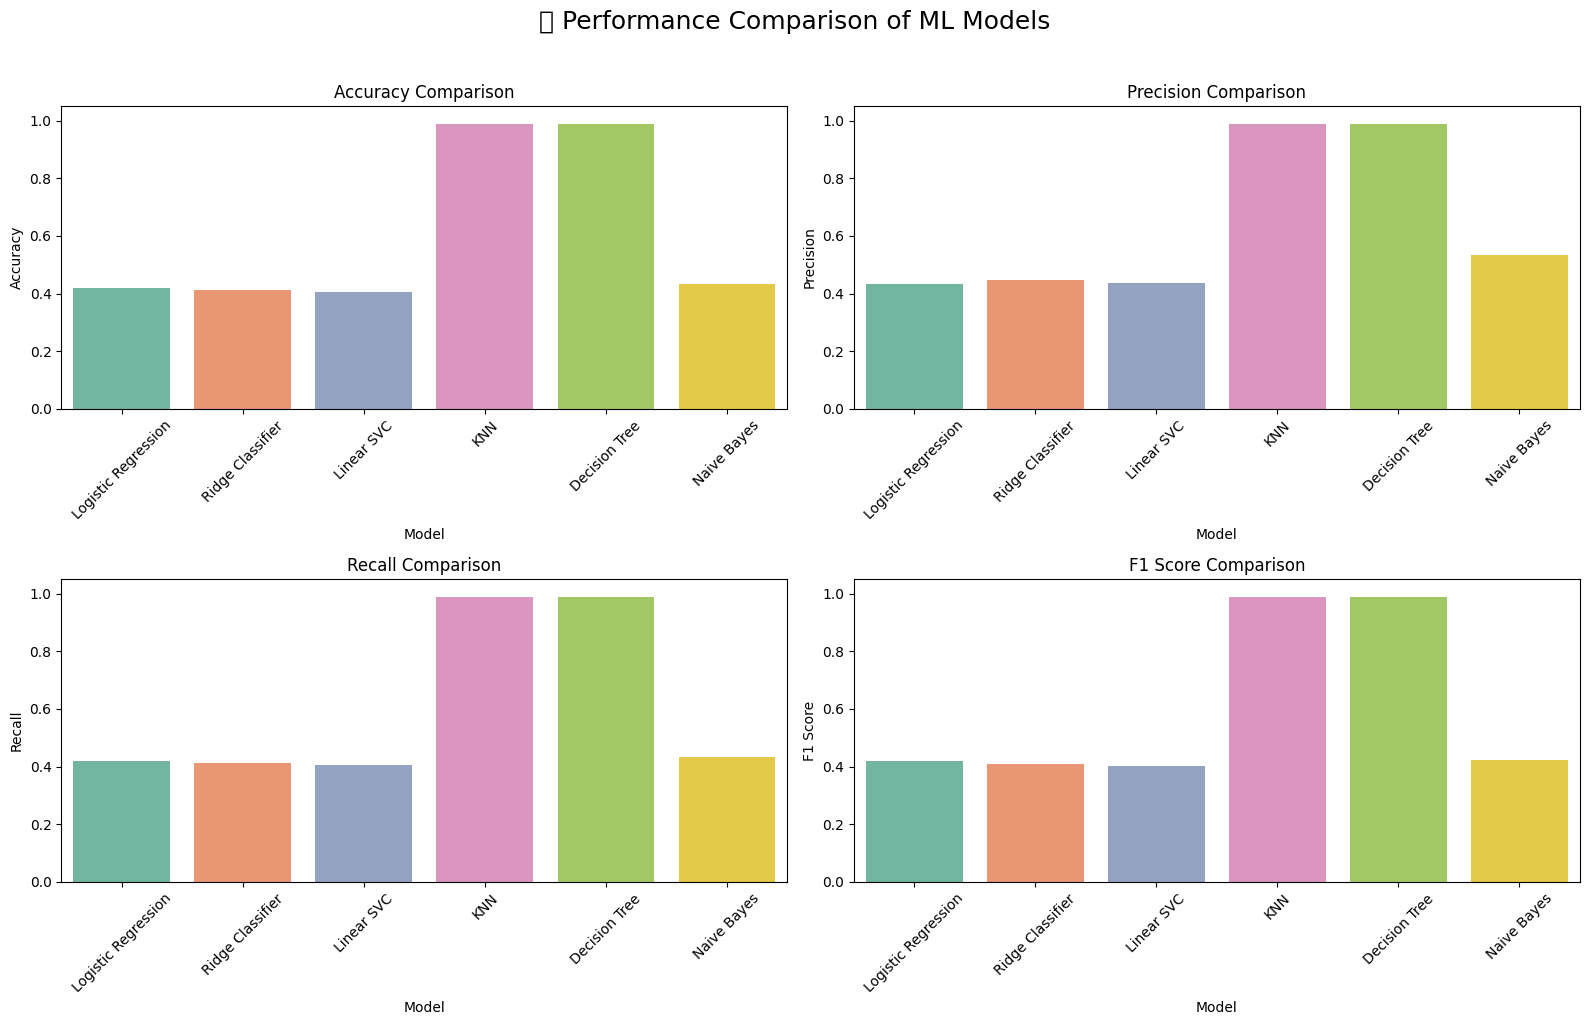

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(16, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(data=results_df, x='Model', y=metric, palette='Set2')
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45)

plt.suptitle("📊 Performance Comparison of ML Models", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\3832980025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y=metric, palette='Set2')
C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\3832980025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y=metric, palette='Set2')
C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\3832980025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y=metric, palette='Set2')
C:\Users\HP ELITEBOOK\AppDat

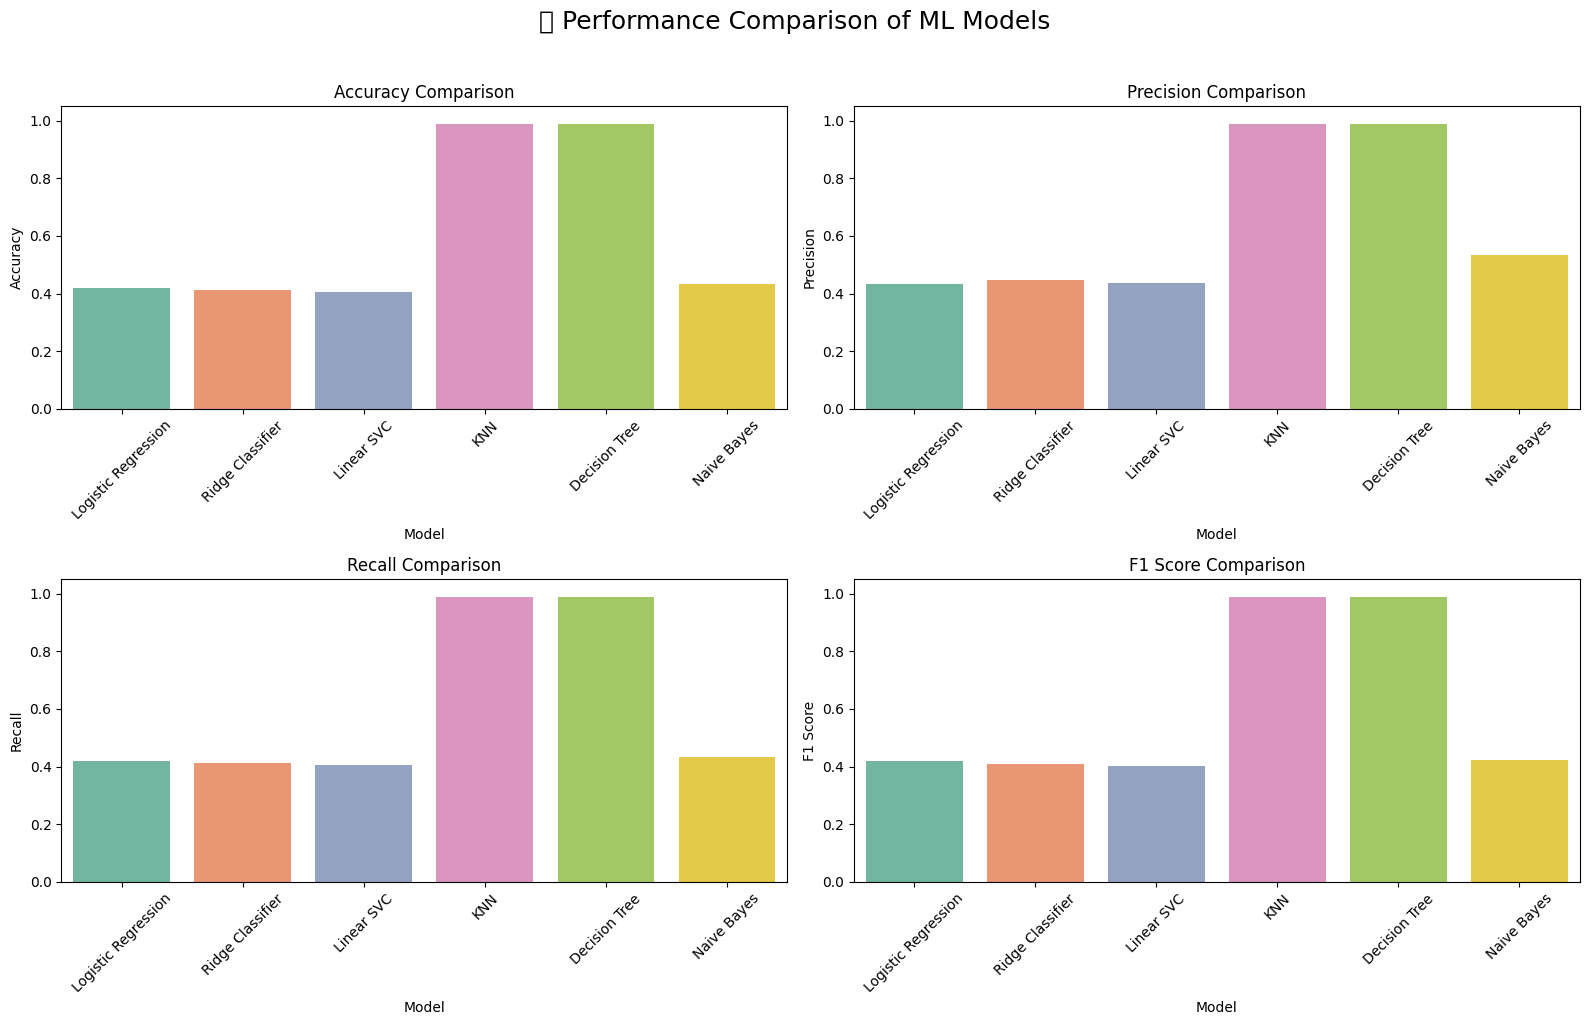

In [24]:
plt.figure(figsize=(16, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(data=results_df, x='Model', y=metric, palette='Set2')
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45)

plt.suptitle("📊 Performance Comparison of ML Models", fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig("model_performance_comparison.png", dpi=300)
plt.show()


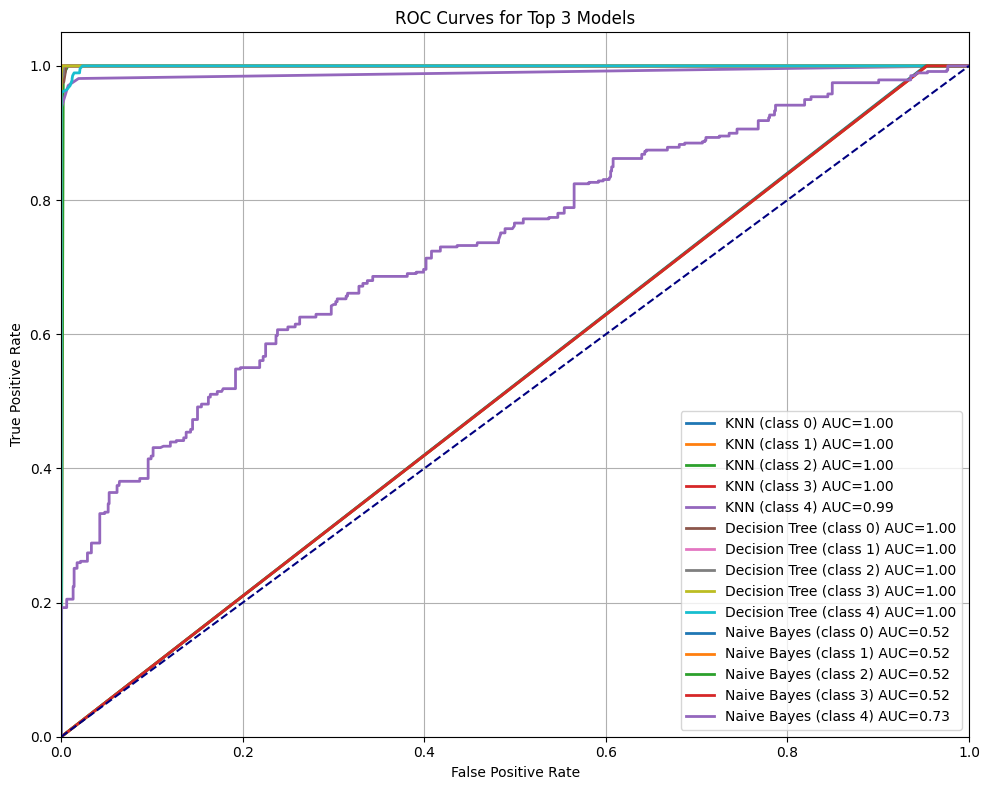

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# For ROC, binarize the labels
y_bin = label_binarize(y_filtered, classes=[0, 1, 3, 4, 5])
n_classes = y_bin.shape[1]

# Split again for ROC
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_bin, test_size=0.2, stratify=y_filtered, random_state=42
)

# Define models
models = {
    "KNN": make_pipeline(StandardScaler(), OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))),
    "Decision Tree": OneVsRestClassifier(DecisionTreeClassifier(max_depth=None, random_state=42)),
    "Naive Bayes": OneVsRestClassifier(GaussianNB())
}

# Plot ROC
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (class {i}) AUC={roc_auc:.2f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Top 3 Models')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig("roc_curves_top3.png", dpi=300)
plt.show()


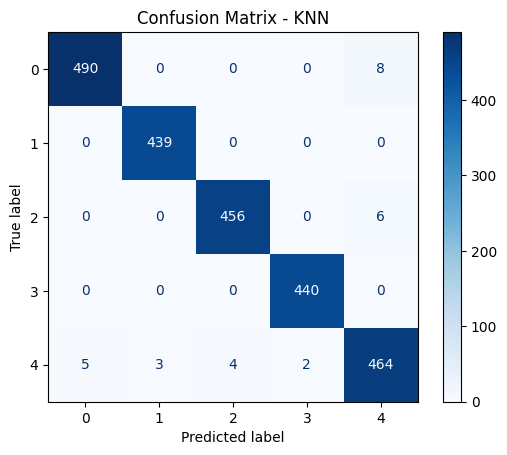

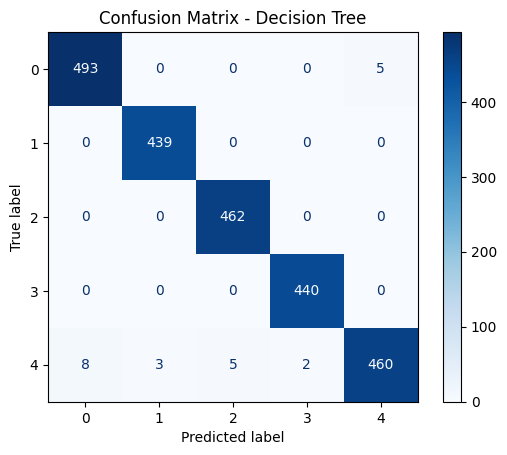

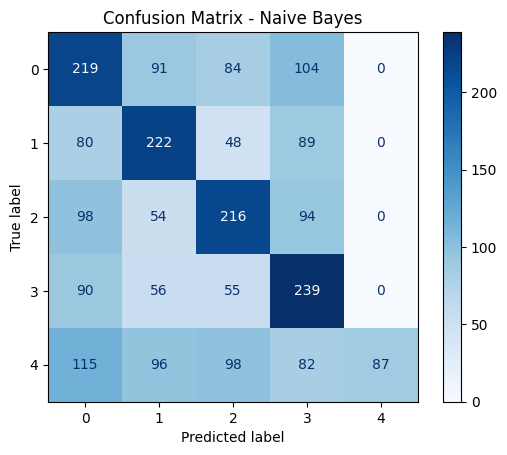

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

top_models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, random_state=42),
    "Naive Bayes": GaussianNB()
}

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)

for name, model in top_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.savefig(f"conf_matrix_{name.replace(' ', '_').lower()}.png", dpi=300)
    plt.show()


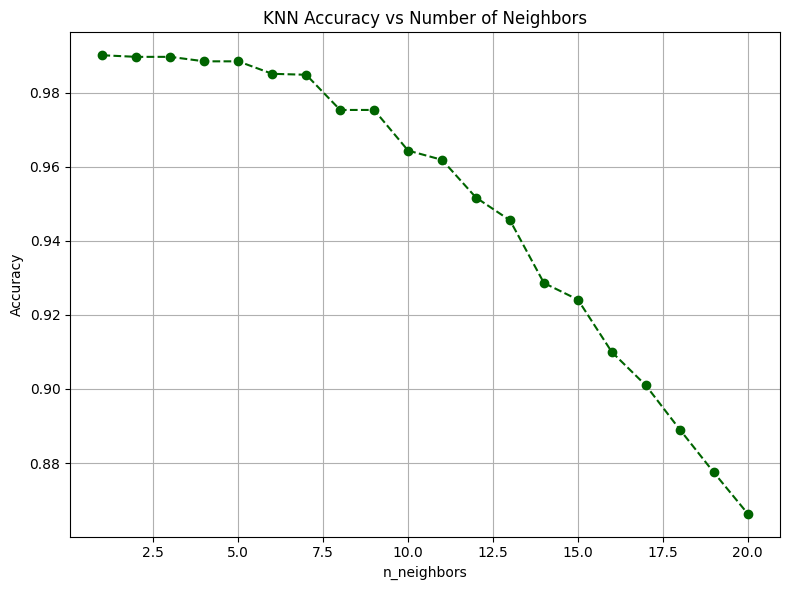

In [27]:
from sklearn.model_selection import cross_val_score

k_vals = range(1, 21)
scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X_filtered, y_filtered, cv=5).mean()
          for k in k_vals]

plt.figure(figsize=(8, 6))
plt.plot(k_vals, scores, marker='o', linestyle='--', color='darkgreen')
plt.title("KNN Accuracy vs Number of Neighbors")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.grid()
plt.tight_layout()
plt.savefig("knn_hyperparameter_plot.png", dpi=300)
plt.show()


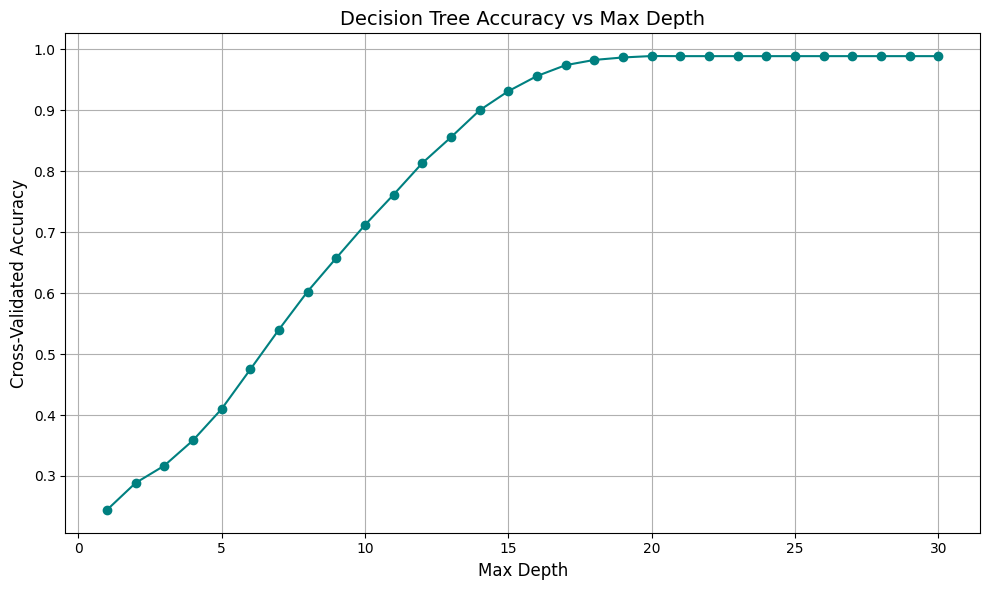

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Evaluate max_depth from 1 to 30
depths = list(range(1, 31))
scores = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    score = cross_val_score(model, X_filtered, y_filtered, cv=5, scoring='accuracy').mean()
    scores.append(score)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(depths, scores, marker='o', linestyle='-', color='teal')
plt.title("Decision Tree Accuracy vs Max Depth", fontsize=14)
plt.xlabel("Max Depth", fontsize=12)
plt.ylabel("Cross-Validated Accuracy", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("decision_tree_hyperparameter_plot.png", dpi=300)
plt.show()


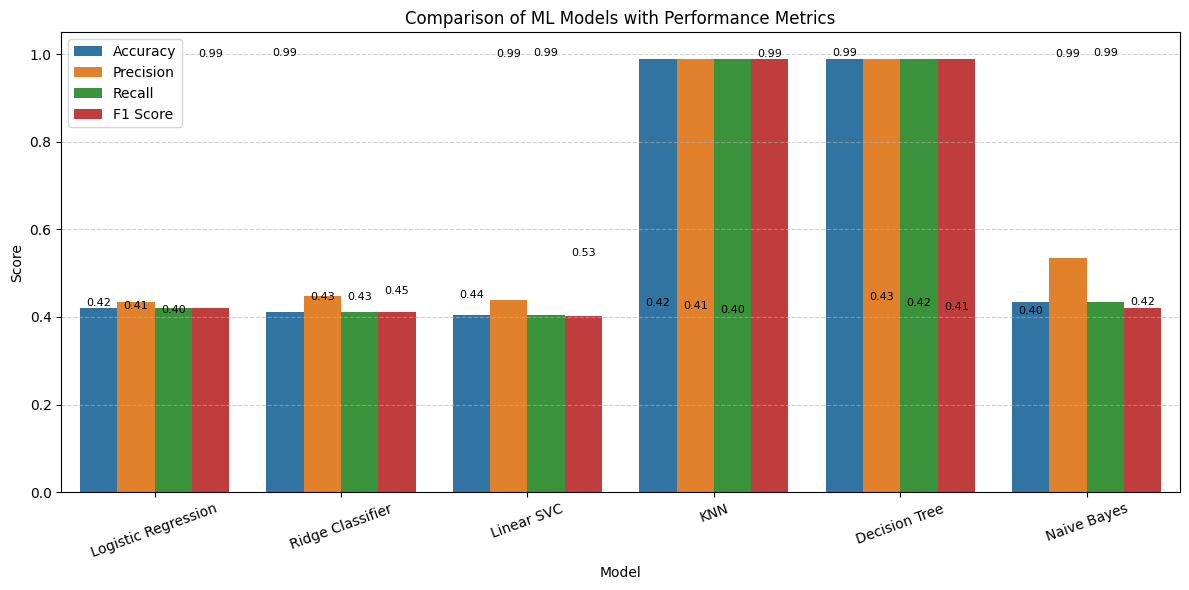

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# DataFrame for model results
model_results = pd.DataFrame({
    "Model": [
        "Logistic Regression", "Ridge Classifier", "Linear SVC",
        "KNN", "Decision Tree", "Naive Bayes"
    ],
    "Accuracy": [0.4195, 0.4122, 0.4044, 0.9888, 0.9901, 0.4346],
    "Precision": [0.4334, 0.4470, 0.4377, 0.9888, 0.9901, 0.5344],
    "Recall": [0.4195, 0.4122, 0.4044, 0.9888, 0.9901, 0.4346],
    "F1 Score": [0.4200, 0.4105, 0.4022, 0.9888, 0.9900, 0.4214]
})

# Melt for plotting
melted = model_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Score", hue="Metric", data=melted, palette="tab10")

# Annotate scores on bars
for i in range(len(melted)):
    plt.text(
        i // 4 + (i % 4) * 0.2 - 0.3,  # x position
        melted["Score"].iloc[i] + 0.005,
        f"{melted['Score'].iloc[i]:.2f}",
        ha='center',
        fontsize=8
    )

plt.title("Comparison of ML Models with Performance Metrics")
plt.xticks(rotation=20)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.tight_layout()
plt.legend(loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig("model_metrics_comparison.png", dpi=300)
plt.show()


C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\943672915.py:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\943672915.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig("feature_correlation_heatmap.png", dpi=300)
C:\Users\HP ELITEBOOK\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


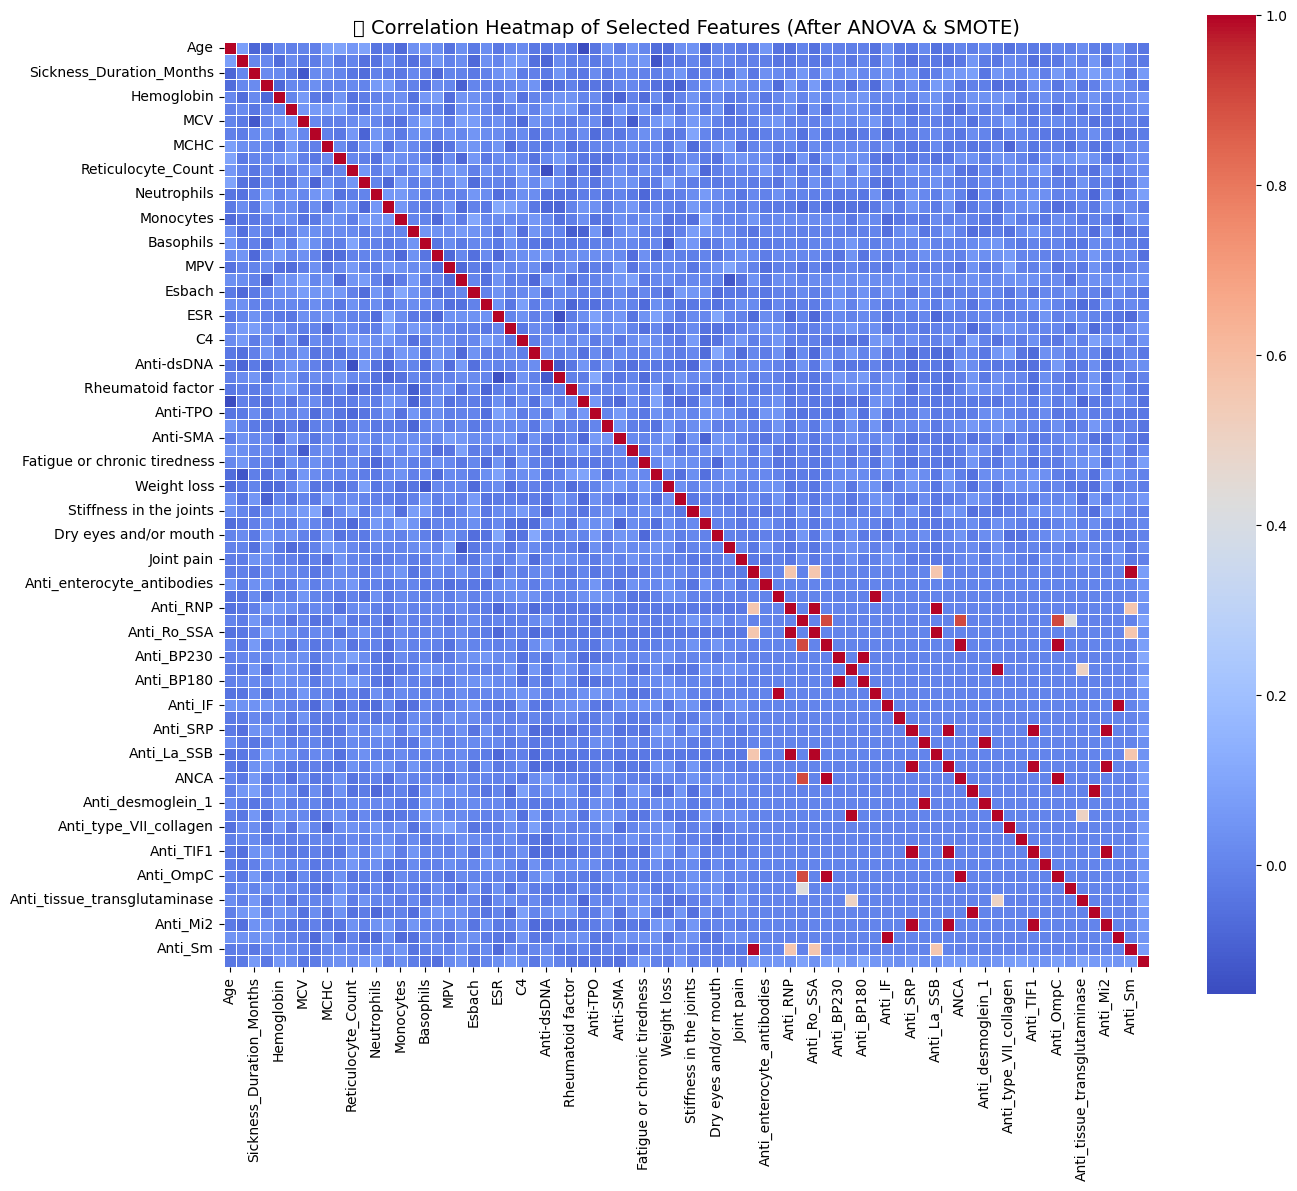

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Reconstruct DataFrame from selected features
df_filtered_features = pd.DataFrame(X_filtered, columns=retained_features)

# Add target for correlation
df_filtered_features["Diagnosis"] = y_filtered.values

# Compute correlation matrix
corr_matrix = df_filtered_features.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", square=True, linewidths=0.5, cbar=True)

plt.title("🔍 Correlation Heatmap of Selected Features (After ANOVA & SMOTE)", fontsize=14)
plt.tight_layout()
plt.savefig("feature_correlation_heatmap.png", dpi=300)
plt.show()


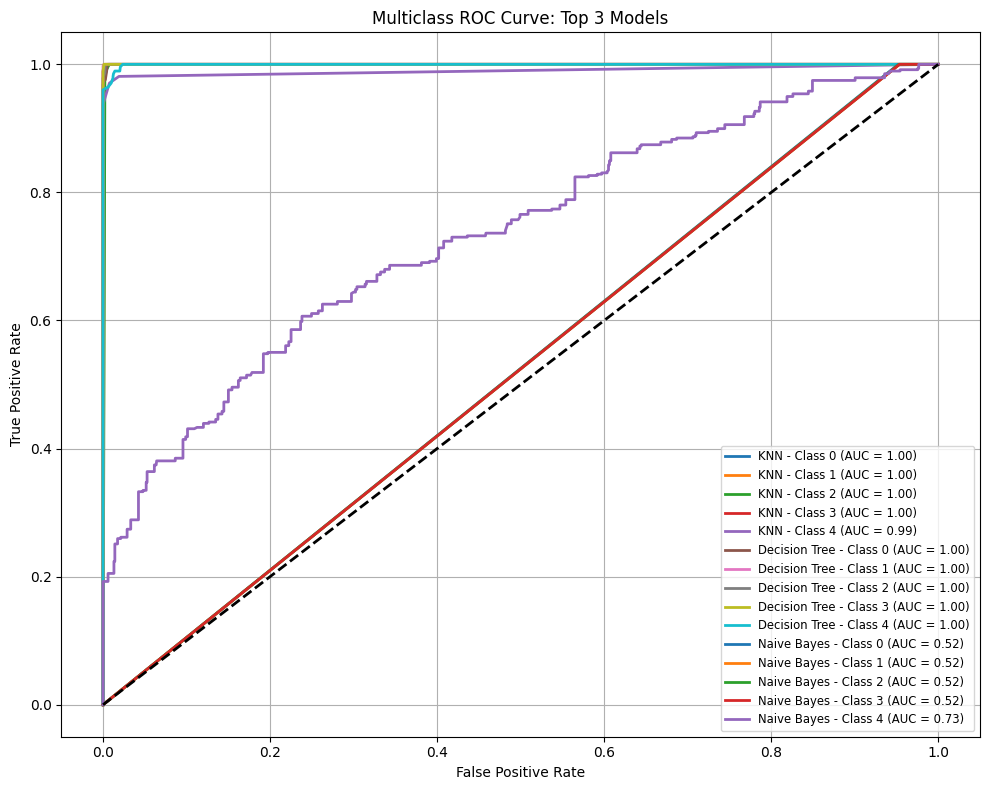

In [32]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels
y_bin = label_binarize(y_filtered, classes=sorted(np.unique(y_filtered)))
n_classes = y_bin.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_bin, test_size=0.2, stratify=y_filtered, random_state=42
)

# Top 3 models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, random_state=42),
    "Naive Bayes": GaussianNB()
}

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange']

# Plot ROC for each class per model
for (name, model), color in zip(models.items(), colors):
    clf = OneVsRestClassifier(model)
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} - Class {i} (AUC = {roc_auc:.2f})", lw=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve: Top 3 Models")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.savefig("top3_models_roc.png", dpi=300)
plt.show()


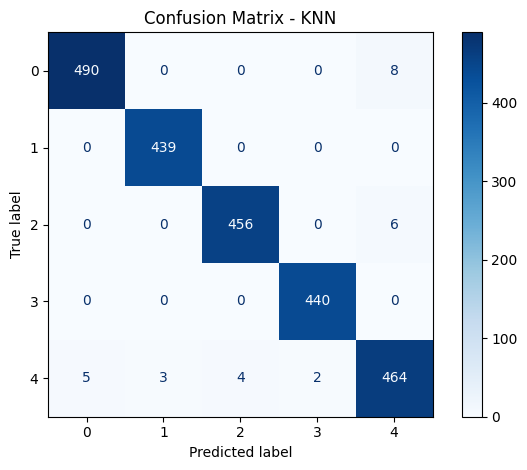

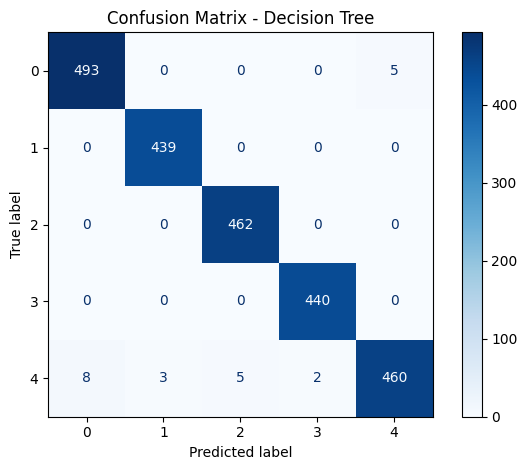

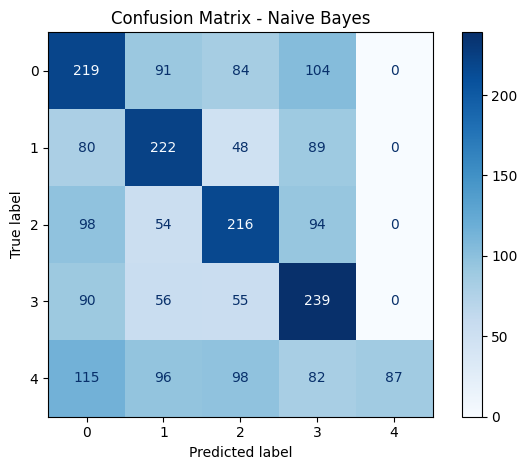

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Unbinarize
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)

for name, model in models.items():
    clf = model.fit(X_train_, y_train_)
    y_pred = clf.predict(X_test_)

    cm = confusion_matrix(y_test_, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.savefig(f"conf_matrix_{name.replace(' ', '_').lower()}.png", dpi=300)
    plt.show()


C:\Users\HP ELITEBOOK\AppData\Local\Temp\ipykernel_8436\792879871.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("combined_confusion_matrices.png", dpi=300, bbox_inches='tight')
C:\Users\HP ELITEBOOK\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


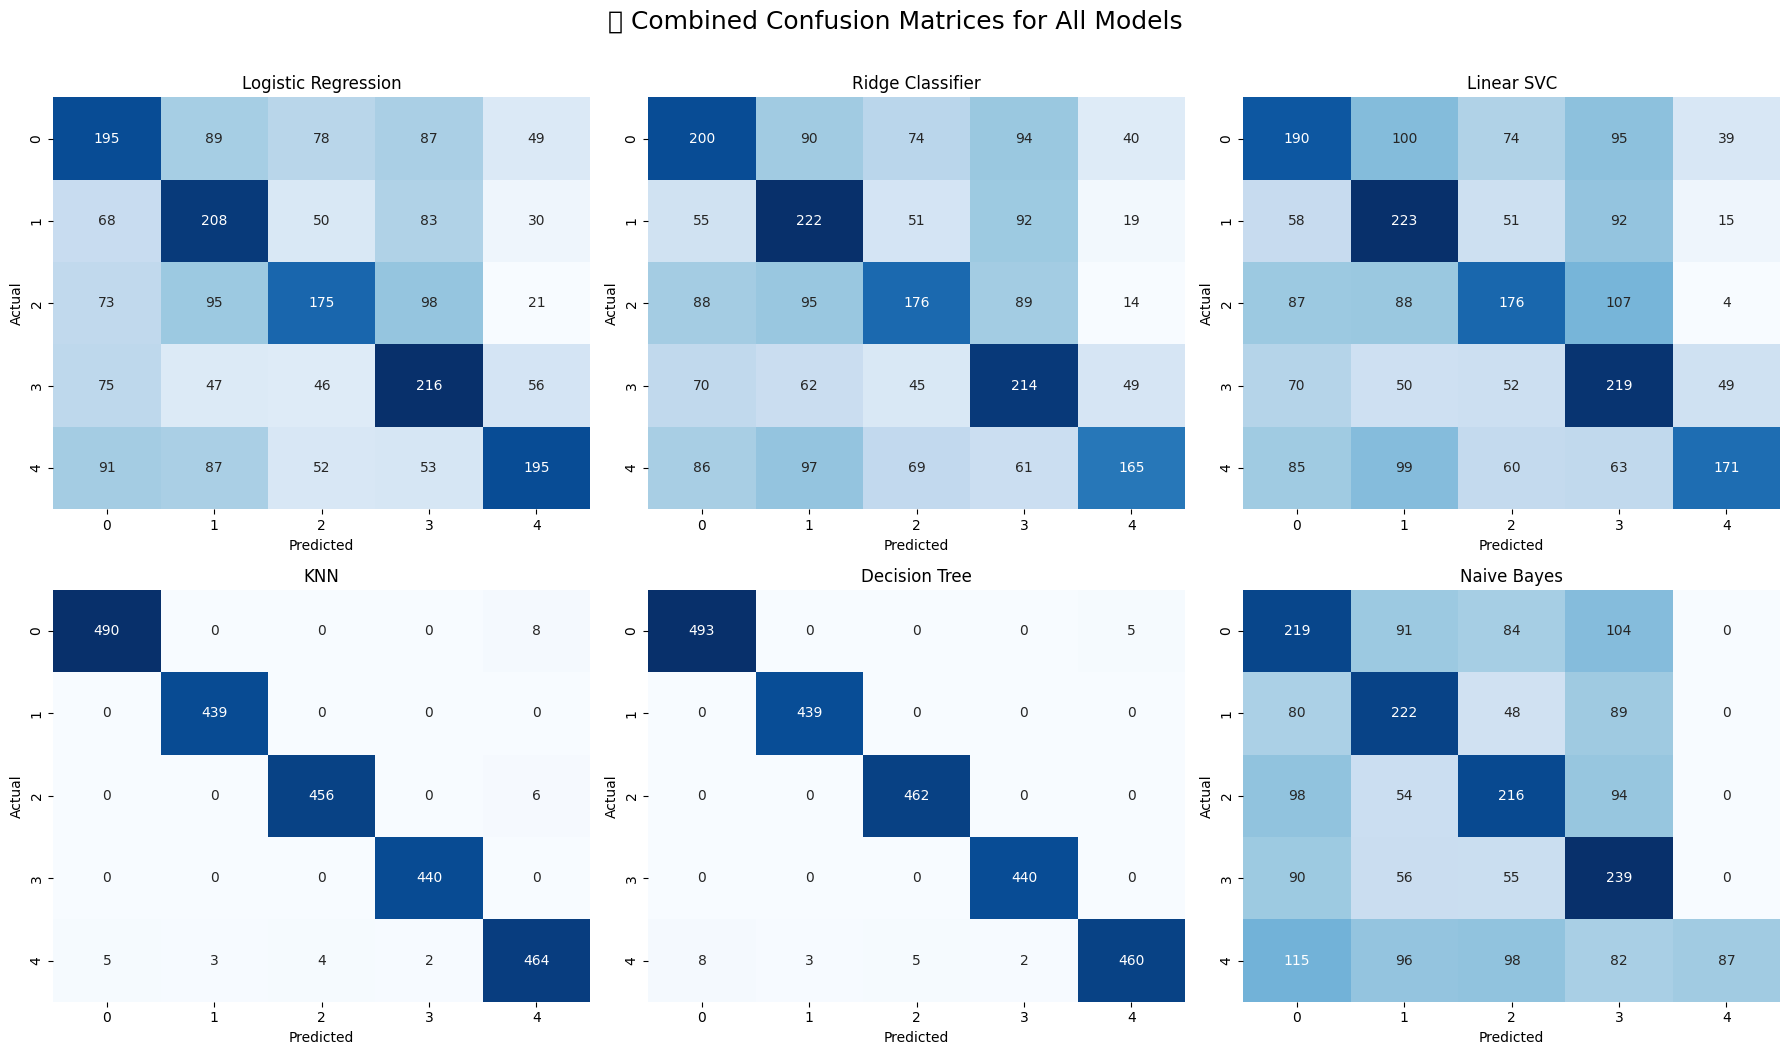

In [34]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split again for consistent test set
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)

# Dictionary of models
models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(C=0.01, max_iter=500)),
    "Ridge Classifier": make_pipeline(StandardScaler(), RidgeClassifier(alpha=10.0)),
    "Linear SVC": make_pipeline(StandardScaler(), LinearSVC(C=0.1, max_iter=1000)),
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Plot confusion matrices in one figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train_, y_train_)
    y_pred = model.predict(X_test_)
    cm = confusion_matrix(y_test_, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(name)
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.suptitle("📊 Combined Confusion Matrices for All Models", fontsize=18, y=1.05)
plt.savefig("combined_confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()


In [35]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Recreate data split without class 2
X_cv = X_selected[y != 2]
y_cv = y[y != 2]

# Initialize SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_cv_res, y_cv_res = smote.fit_resample(X_cv, y_cv)

# CV Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [36]:
models = {
    "Logistic Regression": LogisticRegression(C=0.01, max_iter=1000, random_state=42),
    "Ridge Classifier": RidgeClassifier(alpha=10.0),
    "Linear SVC": LinearSVC(C=0.1, max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, random_state=42),
    "Naive Bayes": GaussianNB()
}


In [ ]:
import pandas as pd

results = []

for name, model in models.items():
    acc = cross_val_score(model, X_cv_res, y_cv_res, cv=cv, scoring='accuracy').mean()
    prec = cross_val_score(model, X_cv_res, y_cv_res, cv=cv, scoring='precision_weighted').mean()
    rec = cross_val_score(model, X_cv_res, y_cv_res, cv=cv, scoring='recall_weighted').mean()
    f1 = cross_val_score(model, X_cv_res, y_cv_res, cv=cv, scoring='f1_weighted').mean()
    
    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1 Score': round(f1, 4)
    })

cv_results_df = pd.DataFrame(results)
print("\n✅ Cross-Validation Results:\n")
print(cv_results_df)
